In [1]:
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
import mne

# graphical libs
from matplotlib import pyplot as plt
%matplotlib widget

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ml libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score, classification_report, mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

from scipy.signal import savgol_filter, filtfilt, butter

import optuna
from optuna.samplers import TPESampler

# set number of rows ti display
#pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output

# Model serialization
import pickle

import serial
import time

In [2]:
# Set requirements
#!pip install -qr ../requirements.txt

In [3]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import get_mse, preprocessing_0, preprocessing_1
from utils.figures import get_signals_plot, get_signals_comparison_plot #get_all_sensors_plot, 

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [4]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in tensorflow 
#tf.random.set_seed(seed_value)

# 4. initiate random seed in Optuna
sampler = TPESampler(seed=seed_value) # fix random seed

Задача: регрессионный анализ координат пальцев протеза по показаниям от датчиков ОМГ.

* X_train.npy - обучающая выборка имеющая размерности  
* X_test.npy - тестоваая выборка имеющая размерности  
* y_train.npy - целевая переменная для обучающей выборки 

In [5]:
# Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
mounts = dict()

with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
    for file in myzip.namelist():
            mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file), index_col=0)

mounts.keys()

dict_keys(['free_movements', 'gestures_protocol', 'gestures_test', 'gestures_train'])

In [6]:
free_movements = mounts['free_movements']

print(free_movements.shape)
free_movements.head()

(20990, 65)


0   1     2    3   4     5   6   7     8   9  ...  GYR2  ENC0  ENC1  \
140  1203  22  1594  123  10  2390  24  32  1848  40  ...   -18    40    53   
141  1204   0  1598  136   2  2396  28  28  1847  42  ...   -12    40    53   
142  1203   0  1599  132  14  2398  20  30  1851  45  ...   -10    40    53   
143  1202  27  1601  115  11  2402  30  22  1858  44  ...   -10    40    53   
144  1207   0  1601  109   4  2404  28  27  1857  43  ...   -10    40    53   

     ENC2  ENC3  ENC4  ENC5  BUTTON  SYNC       ts  
140    55    48    41     0    1000     0  8881644  
141    55    48    41     0    1000     0  8881677  
142    55    48    41     0    1000     0  8881710  
143    55    48    41     0    1000     0  8881743  
144    55    48    41     0    1000     0  8881776  

[5 rows x 65 columns]

In [7]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# [y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом (не используется для свободных движений)
# 'ts' - метка времени
free_movements.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

### Gestures train and test

In [8]:
gestures_train = mounts['gestures_train']

print(gestures_train.shape)
gestures_train.head()

(33172, 65)


0  1     2   3  4     5   6   7     8   9  ...  GYR2  ENC0  ENC1  ENC2  \
0  1605  0  1739  94  6  2618  30  29  2058  40  ...    -1    19    25    22   
1  1604  8  1738  94  7  2618  30  28  2062  40  ...   -14    19    25    21   
2  1607  9  1739  94  7  2624  32  28  2064  43  ...   -17    19    25    21   
3  1597  2  1743  93  5  2612  31  31  2052  39  ...   -15    19    25    21   
4  1595  7  1722  91  8  2603  32  26  2052  37  ...   -10    19    25    21   

   ENC3  ENC4  ENC5  BUTTON  SYNC       ts  
0    11     0     0    1000     0  6492378  
1    11     0     0    1000     0  6492411  
2    11     0     0    1000     0  6492444  
3    11     0     0    1000     0  6492477  
4    11     0     0    1000     0  6492510  

[5 rows x 65 columns]

In [9]:
gestures_test = mounts['gestures_test']

print(gestures_test.shape)
gestures_test.head()

(8168, 65)


0   1     2    3  4     5   6   7     8   9  ...  GYR2  ENC0  ENC1  \
33172  1469  11  1858   99  4  2552  29  39  2190  38  ...    -3     9    12   
33173  1460  11  1857   99  6  2549  31  32  2190  41  ...    -3     9    12   
33174  1471   9  1860  101  6  2554  29  35  2193  39  ...    -6    10    12   
33175  1467   8  1856   98  0  2549  27  36  2190  40  ...   -12    10    12   
33176  1471   6  1859   99  3  2554  28  36  2187  40  ...   -19    10    12   

       ENC2  ENC3  ENC4  ENC5  BUTTON  SYNC       ts  
33172     4     1     0     0    1000   433  7587054  
33173     4     1     0     0    1000   433  7587087  
33174     4     1     0     0    1000   433  7587120  
33175     4     1     0     0    1000   433  7587153  
33176     4     1     0     0    1000   433  7587186  

[5 rows x 65 columns]

In [10]:
# Обозначение колонок для удобства доступа
OMG_CH = [str(i) for i in range(50)]

ACC_CH = config.ACC_CH
GYR_CH = config.GYR_CH
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = config.GLOVE_CH[:-1] # Датчик 'ENC5' не используем
#GLOVE_CH = GLOVE_CH
BUTTON_SYNC_TS_CH = config.BUTTON_SYNC_TS_CH

#assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


In [11]:
X_train_raw, X_test_raw = gestures_train.iloc[:,0:50], gestures_test.iloc[:,0:50]

In [12]:
X_train_raw = gestures_train.iloc[:,0:50].values
X_train_raw

array([[1605,    0, 1739, ...,    4,    9,   48],
       [1604,    8, 1738, ...,    6,    7,   18],
       [1607,    9, 1739, ...,    4,    8,   12],
       ...,
       [1469,    8, 1857, ...,    8,   14,    6],
       [1459,    8, 1855, ...,   12,   10,    6],
       [1469,    8, 1860, ...,    0,   14,   11]], dtype=int64)

In [13]:
X_train = np.transpose([savgol_filter(X_train_raw[:,i], window_length=60, polyorder=4) for i in range(X_train_raw.shape[1])])
X_train

array([[ 1.60623621e+03, -1.54253702e+00,  1.74061230e+03, ...,
         3.35538773e+00,  8.85113146e+00,  2.96340120e+01],
       [ 1.60339276e+03,  1.87978235e+00,  1.73648935e+03, ...,
         3.62795261e+00,  9.11099643e+00,  2.55048094e+01],
       [ 1.60069438e+03,  4.73887044e+00,  1.73287043e+03, ...,
         3.88921408e+00,  9.34776020e+00,  2.18459345e+01],
       ...,
       [ 1.46698189e+03,  1.00659674e+01,  1.85856996e+03, ...,
         6.59842662e+00,  1.17837455e+01,  7.24166871e+00],
       [ 1.46728013e+03,  1.21544054e+01,  1.85945148e+03, ...,
         6.01195825e+00,  1.24588949e+01,  7.55018413e+00],
       [ 1.46758616e+03,  1.46852066e+01,  1.86056988e+03, ...,
         5.31460243e+00,  1.32788060e+01,  7.90181929e+00]])

### Protocol

In [14]:
gestures_protocol = mounts['gestures_protocol']
gestures_protocol.head(10)

Thumb  Index  Middle  Ring  Pinky  id
epoch                                       
0          0      0       0     0      0   1
1        100      0       0     0      0   2
2          0      0       0     0      0   3
3          0      0     100   100    100   4
4          0      0       0     0      0   5
5        100    100       0     0      0   6
6          0      0       0     0      0   7
7        100    100     100   100    100   8
8          0      0       0     0      0   9
9          0      0       0     0      0   1

In [15]:
display(gestures_train['SYNC'].head(2), gestures_train['SYNC'].tail(2))

0    0
1    0
Name: SYNC, dtype: int64

33170    432
33171    432
Name: SYNC, dtype: int64

In [16]:
# Смотрим все признаки вместе (для информации) 
gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)
gestures_train_ext.head()

0  1     2   3  4     5   6   7     8   9  ...  ENC5  BUTTON  SYNC  \
0  1605  0  1739  94  6  2618  30  29  2058  40  ...     0    1000     0   
1  1604  8  1738  94  7  2618  30  28  2062  40  ...     0    1000     0   
2  1607  9  1739  94  7  2624  32  28  2064  43  ...     0    1000     0   
3  1597  2  1743  93  5  2612  31  31  2052  39  ...     0    1000     0   
4  1595  7  1722  91  8  2603  32  26  2052  37  ...     0    1000     0   

        ts  Thumb  Index  Middle  Ring  Pinky  id  
0  6492378      0      0       0     0      0   1  
1  6492411      0      0       0     0      0   1  
2  6492444      0      0       0     0      0   1  
3  6492477      0      0       0     0      0   1  
4  6492510      0      0       0     0      0   1  

[5 rows x 71 columns]

In [17]:
gestures_train['ts'].head()

0    6492378
1    6492411
2    6492444
3    6492477
4    6492510
Name: ts, dtype: int64

## Composition of X_train

In [18]:
X_train_raw, X_test_raw = gestures_train.iloc[:,0:50], gestures_test.iloc[:,0:50] #56
# Предобработка скользящим окном
#X_train, X_test = X_train.rolling(window=3).mean().dropna(axis=0), X_test.rolling(window=3).mean().dropna(axis=0)

display('X_train', X_train_raw.head(2))

'X_train'

0  1     2   3  4     5   6   7     8   9  ...  40  41  42  43  44  45  \
0  1605  0  1739  94  6  2618  30  29  2058  40  ...  20   9   8  32   4   9   
1  1604  8  1738  94  7  2618  30  28  2062  40  ...  20  10  10  31   7  11   

   46  47  48  49  
0  22   4   9  48  
1  24   6   7  18  

[2 rows x 50 columns]

In [19]:
# scaler = StandardScaler() 
# X_train_s, X_test_s = scaler.fit_transform(X_train), scaler.fit_transform(X_test)
# X_train_s = pd.DataFrame(X_train_s, columns=X_train.columns)
# X_train_s.head(2)

In [20]:
y_train, y_test = gestures_train[GLOVE_CH], gestures_test[GLOVE_CH]

# Предобработка скользящим окном
#y_train, y_test =  y_train.iloc[2:,:], y_test.iloc[2:,]
display('y_train', y_train.head(2), 'y_test', y_test.head(2)) 

'y_train'

ENC0  ENC1  ENC2  ENC3  ENC4
0    19    25    22    11     0
1    19    25    21    11     0

'y_test'

ENC0  ENC1  ENC2  ENC3  ENC4
33172     9    12     4     1     0
33173     9    12     4     1     0

In [21]:
X_free, y_free = free_movements.iloc[:,0:50], free_movements[GLOVE_CH]

display(X_free.head(2),'X_free', X_free.shape, y_free.head(2),y_free.shape)

0   1     2    3   4     5   6   7     8   9  ...  40  41  42  43  44  \
140  1203  22  1594  123  10  2390  24  32  1848  40  ...  13  10   9  32   5   
141  1204   0  1598  136   2  2396  28  28  1847  42  ...  18   5  12  26  10   

     45  46  47  48  49  
140   9  24   5   7   9  
141  11  17   1   5   6  

[2 rows x 50 columns]

'X_free'

(20990, 50)

ENC0  ENC1  ENC2  ENC3  ENC4
140    40    53    55    48    41
141    40    53    55    48    41

(20990, 5)

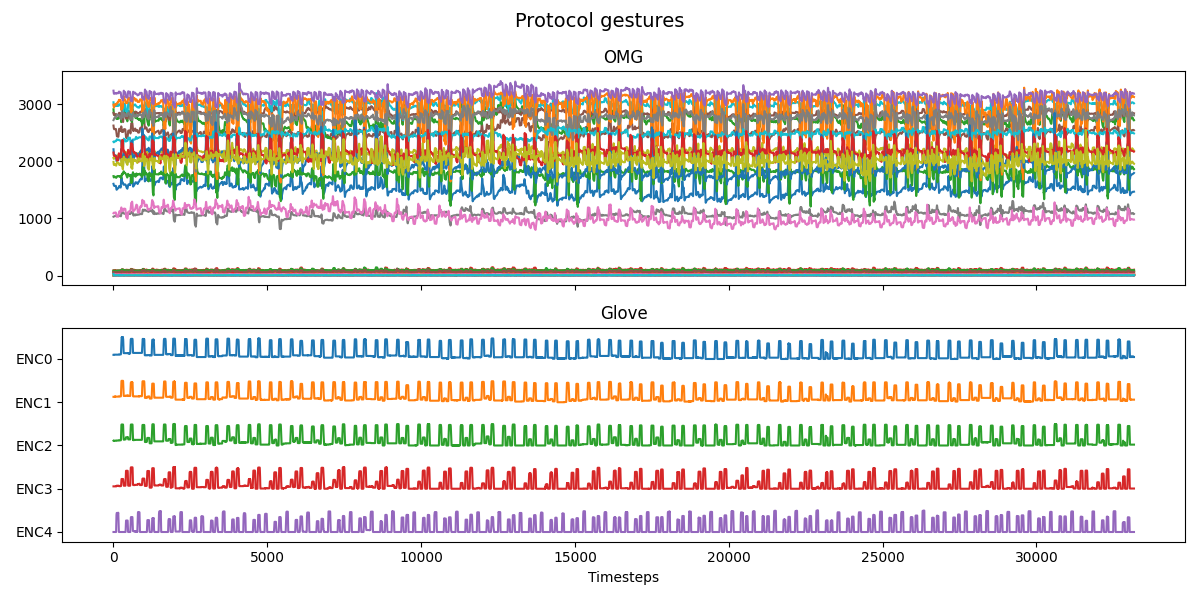

In [22]:
get_signals_plot(X_train, y_train, 'Protocol gestures')

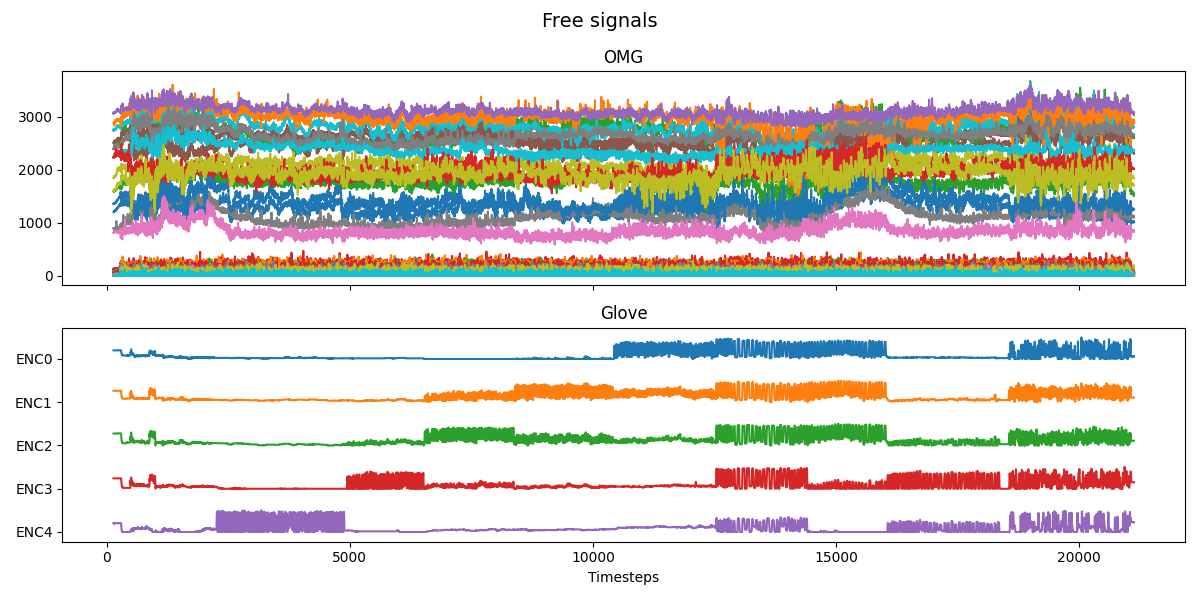

In [23]:
get_signals_plot(X_free, y_free, 'Free signals')

# Preprocessing

In [24]:
X_train = np.transpose([savgol_filter(X_train_raw.iloc[:,i], window_length=60, polyorder=4) for i in range(X_train_raw.shape[1])]) 
X_test = np.transpose([savgol_filter(X_test_raw.iloc[:,i], window_length=60, polyorder=4) for i in range(X_test_raw.shape[1])])
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

X_train_prep1 = np.transpose([preprocessing_1(b=1, a=0.1, col=X_train_raw.iloc[:,i]) for i in range(X_train_raw.shape[1])])
X_test_prep1 = np.transpose([preprocessing_1(b=1, a=0.1, col=X_test_raw.iloc[:,i]) for i in range(X_test_raw.shape[1])])
X_train_prep1, X_test_prep1 = pd.DataFrame(X_train_prep1), pd.DataFrame(X_test_prep1)

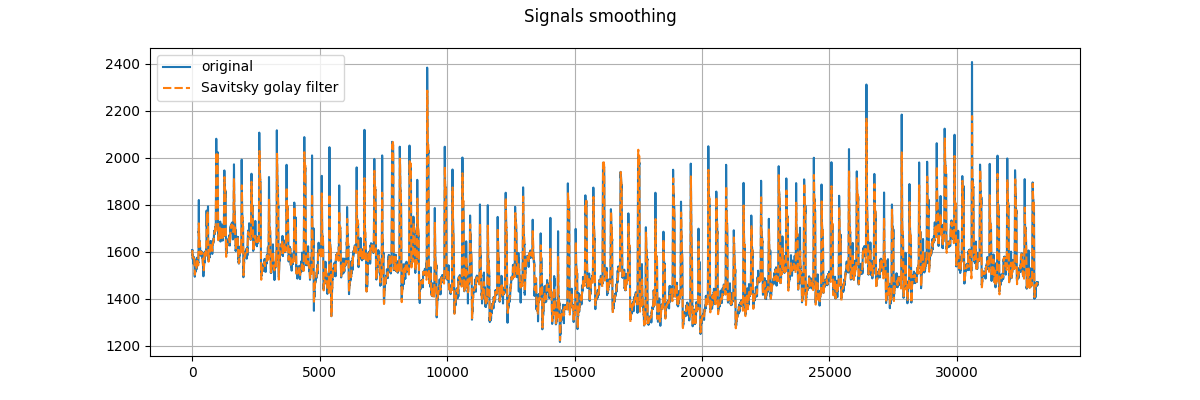

In [25]:
# Smoothing of sensor 0 signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
temp = pd.DataFrame({
    'original':X_train_raw.iloc[:,0], 
    'Savitsky golay filter':X_train.iloc[:,0], 
    #'digital filter':X_train_prep1.iloc[:,0]
})
sns.lineplot(temp)
plt.suptitle('Signals smoothing')
plt.grid()

# Modeling

### Linear regression

In [ ]:
# Creation an instance
lin = LinearRegression()

# Train the Model
lin.fit(X_train, y_train)

# Predict target values
y_pred= pd.DataFrame(lin.predict(X_test), columns=GLOVE_CH, index=gestures_test['ts']).round()

# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred,only_test=1)

### Desision tree

In [ ]:
model = DecisionTreeRegressor()

model.fit(
    X=gestures_train[OMG_CH].values,
    y=gestures_train[GLOVE_CH].values
)

# y_pred_train = pd.DataFrame(model.predict(gestures_train[OMG_CH].values), columns=GLOVE_CH, index=gestures_train['ts'])

y_pred_test = model.predict(gestures_test[OMG_CH].values)
y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test['ts'])

get_mse(y_test, y_pred_test)

MSE metrics for Test: 
--------


ENC0     67.333497
ENC1     76.912708
ENC2     69.425930
ENC3    374.204089
ENC4    755.806195
dtype: float64

In [ ]:
y_pred_train = pd.DataFrame(model.predict(gestures_train[OMG_CH].values), columns=GLOVE_CH)
get_mse(y_train, y_pred_train)

MSE metrics for Test: 
--------


ENC0    0.0
ENC1    0.0
ENC2    0.0
ENC3    0.0
ENC4    0.0
dtype: float64

### Multioutput

MSE metrics for Test: 
--------


ENC0     57.252953
ENC1     37.579762
ENC2     48.509952
ENC3    263.154474
ENC4    546.546531
dtype: float64

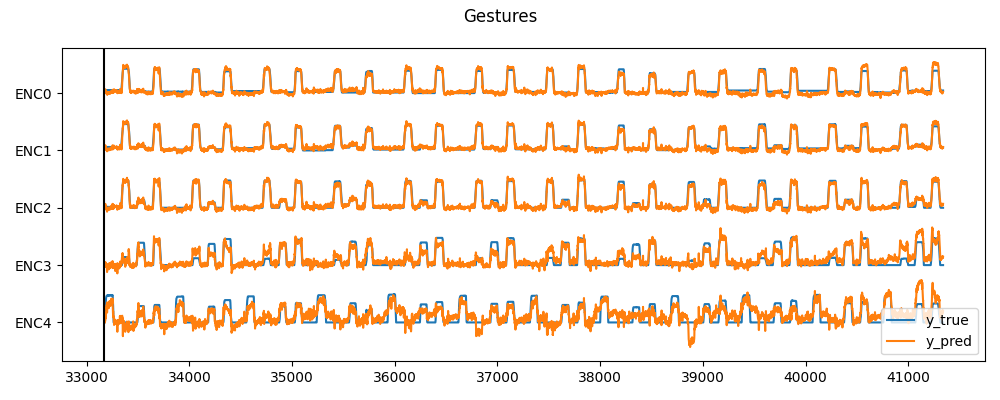

In [ ]:
Mout = MultiOutputRegressor(Ridge(random_state=seed_value))
# Model training
Mout.fit(X_train, y_train)

# Predict target values
y_pred = Mout.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=GLOVE_CH, index=gestures_test['ts'])

# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

MSE metrics for Test: 
--------


ENC0     64.722025
ENC1     37.286490
ENC2     42.524425
ENC3    183.042352
ENC4    364.488992
dtype: float64

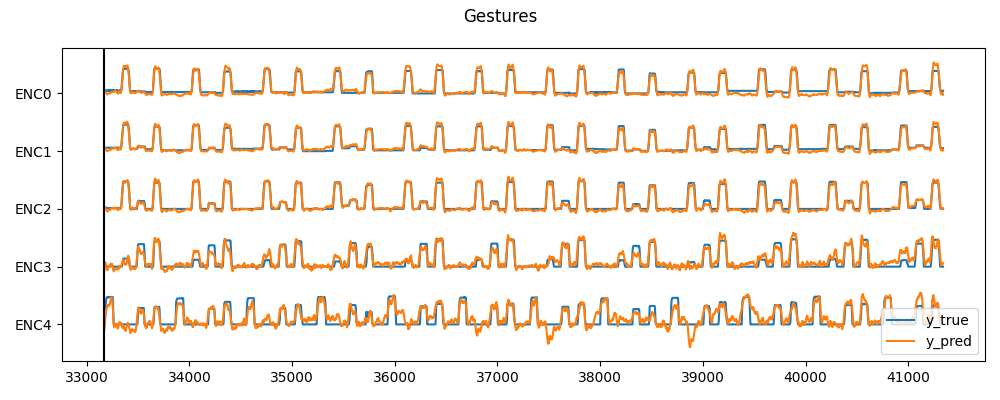

In [ ]:
Mout = MultiOutputRegressor(Ridge(random_state=seed_value))
# Model training
Mout.fit(X_train_prep, y_train)

# Predict target values
y_pred = Mout.predict(X_test_prep)
y_pred = pd.DataFrame(y_pred, columns=GLOVE_CH, index=gestures_test['ts'])

# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

MSE metrics for Test: 
--------


ENC0     62.637182
ENC1     34.769399
ENC2     37.617464
ENC3    181.516748
ENC4    381.216450
dtype: float64

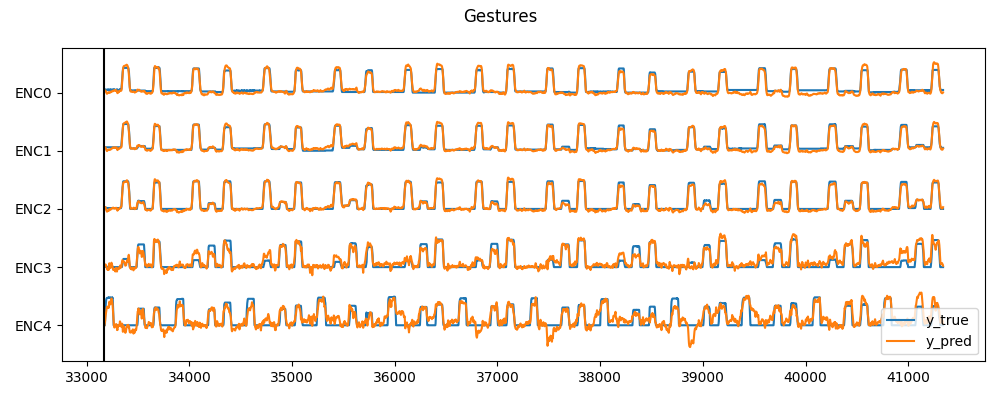

In [ ]:
Mout = MultiOutputRegressor(Ridge(random_state=seed_value))
# Model training
Mout.fit(X_train_prep1, y_train)

# Predict target values
y_pred = Mout.predict(X_test_prep1)
y_pred = pd.DataFrame(y_pred, columns=GLOVE_CH, index=gestures_test['ts'])

# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

### Random forest

MSE metrics for Test: 
--------


ENC0     36.869368
ENC1     35.426420
ENC2     28.617654
ENC3    199.885162
ENC4    387.421401
dtype: float64

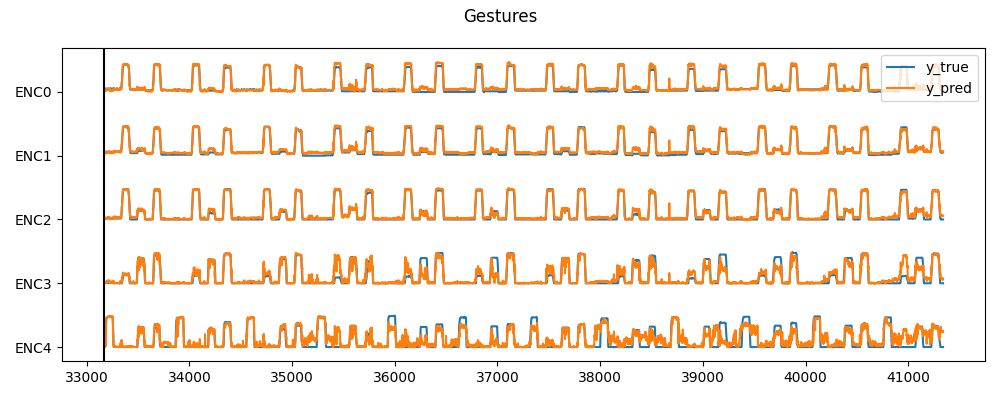

In [62]:
rfr = RandomForestRegressor(
    n_estimators=100, 
    verbose=0, n_jobs=-1,
    #max_depth=6, min_samples_leaf=2,
    random_state=seed_value)

# Model training
rfr.fit(X_train, y_train)

# Prediction target values and transforming it to a DataFrame
#y_pred_rfr = rfr.predict(X_test_s)
y_pred_rfr = pd.DataFrame(rfr.predict(X_test), columns=GLOVE_CH, index=gestures_test['ts']).round()

# Display metrics
get_mse(y_test, y_pred_rfr)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred_rfr,only_test=1) #

MSE metrics for Test: 
--------


ENC0     35.545544
ENC1     40.198457
ENC2     37.068683
ENC3    147.322968
ENC4    367.225269
dtype: float64

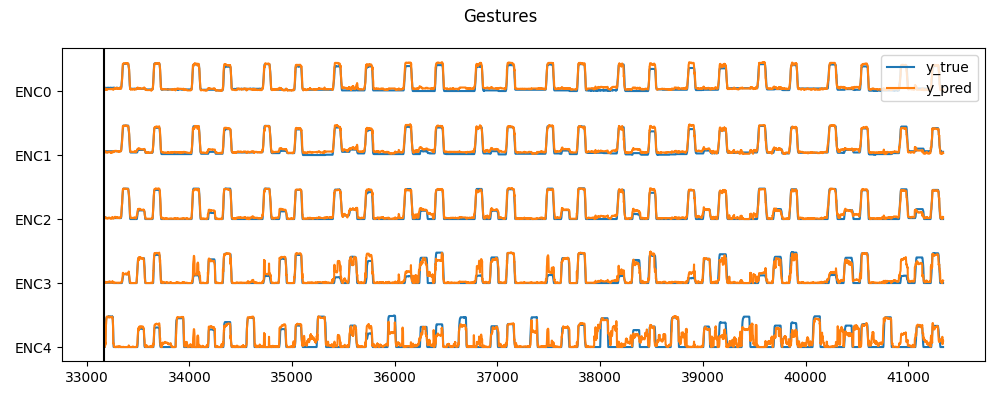

In [63]:
rfr = RandomForestRegressor(
    n_estimators=100, 
    verbose=0, n_jobs=-1,
    #max_depth=6, min_samples_leaf=2,
    random_state=seed_value)

# Model training
rfr.fit(X_train_prep, y_train)

# Prediction target values and transforming it to a DataFrame
#y_pred_rfr = rfr.predict(X_test_s)
y_pred_rfrr = pd.DataFrame(rfr.predict(X_test_prep), columns=GLOVE_CH, index=gestures_test['ts']).round()

# Display metrics
get_mse(y_test, y_pred_rfrr)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred_rfrr, only_test=1) #

MSE metrics for Test: 
--------


ENC0     36.752816
ENC1     41.154383
ENC2     36.798115
ENC3    144.001714
ENC4    470.976004
dtype: float64

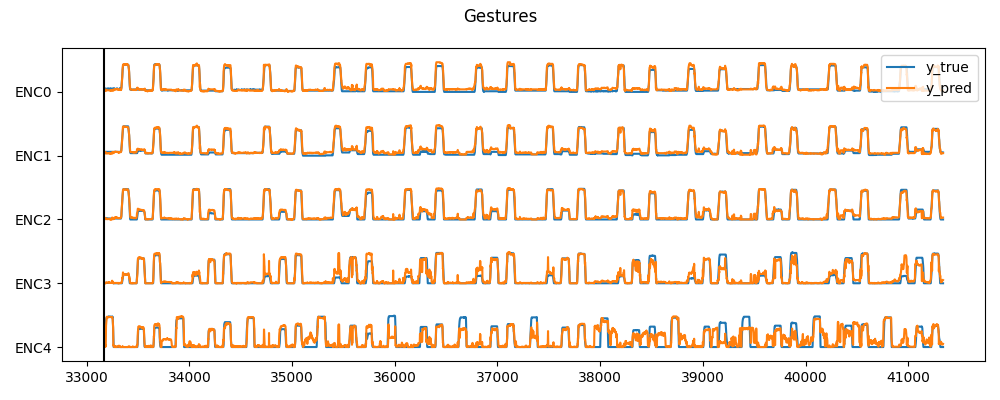

In [64]:
rfr.fit(X_train_prep1, y_train)

# Prediction target values and transforming it to a DataFrame
#y_pred_rfr = rfr.predict(X_test_s)
y_pred_rfrr = pd.DataFrame(rfr.predict(X_test_prep1), columns=GLOVE_CH, index=gestures_test['ts']).round()

# Display metrics
get_mse(y_test, y_pred_rfrr)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred_rfrr, only_test=1) #

In [ ]:
y_pred_train = pd.DataFrame(rfr.predict(gestures_train[OMG_CH].values), columns=GLOVE_CH)
get_mse(y_train, y_pred_train)

MSE metrics for Test: 
--------


ENC0    5150.789545
ENC1    4875.678996
ENC2    5815.417559
ENC3    2901.643609
ENC4    1309.028062
dtype: float64

### Random forest + Optuna

In [ ]:
def optuna_rfr(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 275, 375, 5)
    max_depth = trial.suggest_int('max_depth', 2, 6, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 4 , 1)
    #min_samples_split = trial.suggest_int('min_samples_split', 2,4,1)
    #criterion = trial.suggest_categorical('criterion', ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    
    # model creation 
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        verbose=0, n_jobs=-1,
        min_samples_leaf = min_samples_leaf, 
        #criterion = criterion,
        #min_samples_split = min_samples_split,
        random_state=seed_value
    )
    
    # training
    model.fit(X_train, y_train)
    
    score = mean_squared_error(y_test, model.predict(X_test))

    return score 

In [ ]:
%%time
# create study set
study = optuna.create_study(study_name="RandomForestRegressor_MF", direction="minimize", sampler=sampler)
# try multiple times
study.optimize(optuna_rfr, n_trials=10)
clear_output(wait=False)

optuna.visualization.plot_optimization_history(study, target_name="MSE_score")

CPU times: total: 15min 53s
Wall time: 1min 13s


In [ ]:
study.best_params

{'n_estimators': 330, 'max_depth': 6, 'min_samples_leaf': 2}

In [ ]:
# Apply best parameters
rfr_mf_opt = RandomForestRegressor(
    **study.best_params,  n_jobs=-1, 
    random_state=seed_value
)
# Model training
rfr_mf_opt.fit(X_train, y_train)

# Predict target values
y_pred_rfr_opt = rfr_mf_opt.predict(X_test)

y_pred_rfr_opt = pd.DataFrame(y_pred_rfr_opt, columns=GLOVE_CH, index=gestures_test['ts']).round()
get_mse(y_test, y_pred_rfr_opt)

MSE metrics for Test: 
--------


ENC0     44.306440
ENC1     49.707272
ENC2     40.093046
ENC3    236.496572
ENC4    473.658056
ENC5      0.000000
dtype: float64

### Gradient boosting

In [ ]:
model = MultiOutputRegressor(GradientBoostingRegressor(
        max_features='auto',
        random_state=seed_value)
    )
    
# training
model.fit(X_train_prep1, y_train)

y_pred = pd.DataFrame(model.predict(X_test_prep1), columns=GLOVE_CH, index=gestures_test['ts']).round()

# Display metrics
get_mse(y_test, y_pred)

get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

KeyboardInterrupt: 

In [ ]:
def optuna_gbr(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 40, 250, 1)
    max_depth = trial.suggest_int('max_depth', 2, 15, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.99)
    min_samples_leaf = trial.suggest_int('max_depth', 2, 15, 1)
   
    # model creation 
    model = MultiOutputRegressor(GradientBoostingRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators, 
        max_features='auto',
        min_samples_leaf = min_samples_leaf,
        learning_rate=learning_rate,
        random_state=seed_value)
    )
    
    # training
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse_score = mean_squared_error(y_test, y_pred)

    return mse_score 

In [ ]:
# create study set
study = optuna.create_study(study_name="GradientBoostingRegressor", direction="minimize", sampler=sampler)
# try multiple times
study.optimize(optuna_gbr, n_trials=10)

clear_output(wait=False)

optuna.visualization.plot_optimization_history(study, target_name="mean_squared_error")

In [ ]:
study.best_params

{'n_estimators': 181, 'max_depth': 4, 'learning_rate': 0.13634777170175624}

In [ ]:
Mout_gb = MultiOutputRegressor(GradientBoostingRegressor(
    **study.best_params, 
    random_state=seed_value))
# Model training
Mout_gb.fit(X_train, y_train)

# Predict target values
y_pred = Mout_gb.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=GLOVE_CH, index=gestures_test['ts'])

# Display metrics
get_mse(y_test, y_pred)

MSE metrics for Test: 
--------


ENC0     32.808160
ENC1     27.270646
ENC2     27.486003
ENC3    188.226915
ENC4    295.684444
ENC5      0.000000
dtype: float64

## Гипотезы и тесты

### Выделение активных датчиков

In [ ]:
# Разделим датчики по величине амплитуды равной 200 
sign, nonsign = list(), list()

for i in range(X_train.shape[1]):
    if X_train.iloc[:,i].max()>250:
        sign.append(i)
    else:
        nonsign.append(i)
print('Активные: ', sign, '\nПассивные:',nonsign)

X_train_a, X_test_a = gestures_train.iloc[:,sign], gestures_test.iloc[:,sign] #56
display('X_train', X_train_a.head(2))

Активные:  [0, 2, 3, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38] 
Пассивные: [1, 4, 6, 7, 9, 10, 11, 13, 14, 16, 18, 20, 22, 23, 25, 26, 28, 31, 32, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


'X_train'

0     2   3     5     8    12    15    17    19    21    24    27    29  \
0  1605  1739  94  2618  2058  2893  2840  1032  3022  3003  3235  2726  2344   
1  1604  1738  94  2618  2062  2912  2845  1035  3026  2989  3236  2723  2342   

     30    33    36    38  
0  2198  2152  1094  1982  
1  2205  2148  1094  1982

In [ ]:
rfr_a = RandomForestRegressor(
    n_estimators=315, 
    verbose=0, n_jobs=-1,
    #max_depth=6, min_samples_leaf=2,
    random_state=seed_value)

# Model training
rfr_a.fit(X_train_a, y_train)

# Predict target values
y_pred_rfr_a = rfr_a.predict(X_test_a)

#print(f'MSE {round(mean_squared_error(y_test, y_pred_rfr),2)}')

y_pred_rfr_a = pd.DataFrame(y_pred_rfr_a, columns=GLOVE_CH, index=gestures_test['ts'])
get_mse(y_test, y_pred_rfr_a)

MSE metrics for Test: 
--------


ENC0     32.223431
ENC1     31.372756
ENC2     37.362858
ENC3    306.366086
ENC4    387.535444
ENC5      0.000000
dtype: float64

> При обучении моделей на показаниях датчиков (амплитуда выше 200) метрики практически не изменяются

### Выделение лучшего куска X_train

In [ ]:
X_train_best, X_test = gestures_train.iloc[10000:20000,0:50], gestures_test.iloc[:,0:50] #56
display('X_train', X_train_best.head(2))
#y_train, y_test = gestures_train[['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4' ]], gestures_test[['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']]
y_train_best, y_test = gestures_train[GLOVE_CH].iloc[10000:20000], gestures_test[GLOVE_CH]

'X_train'

0   1     2   3  4     5   6   7     8   9  ...  40  41  42  43  44  \
10000  1499  13  1822  79  4  2505  31  34  2168  40  ...  19  11   4  32   0   
10001  1499  14  1822  98  5  2507  30  30  2155  39  ...  18   9  13  30   4   

       45  46  47  48  49  
10000  12  25  10  10   6  
10001  10  22   0  11   7  

[2 rows x 50 columns]

MSE metrics for Test: 
--------


ENC0      82.629584
ENC1      65.526414
ENC2      61.113071
ENC3     319.869268
ENC4    1359.306689
ENC5       0.000000
dtype: float64

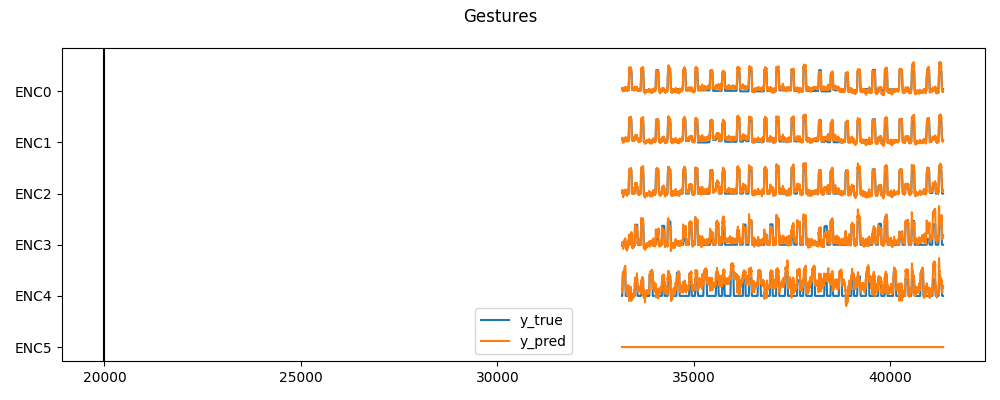

In [ ]:
Mout = MultiOutputRegressor(Ridge(random_state=seed_value))
# Model training
Mout.fit(X_train_best, y_train_best)

# Predict target values
y_pred = Mout.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=GLOVE_CH, index=gestures_test['ts'])

# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train_best, y_test, y_pred=y_pred, only_test=1)

> При обучении на лучшем куске X_train с 10.000 по 20.000 период метрики практически не изменяются

### Раздельное обучение моделей

In [ ]:
y_train_3, y_test_3 = gestures_train['ENC3'], gestures_test['ENC3']
y_train_4, y_test_4 = gestures_train['ENC4'], gestures_test['ENC4']

In [ ]:
rfr_sep3 = RandomForestRegressor(
    #n_estimators=315, 
    verbose=0, n_jobs=-1,
    #max_depth=6, min_samples_leaf=2,
    random_state=seed_value)

# Model training
rfr_sep3.fit(X_train, y_train_3)

# Predict target values
y_pred_rfr_sep3 = rfr_sep3.predict(X_test)

y_pred_rfr_sep3 = pd.DataFrame(y_pred_rfr_sep3, columns=['ENC3'], index=gestures_test['ts'])
mean_squared_error(y_test_3, y_pred_rfr_sep3).round(2)

190.5

In [ ]:
rfr_sep4 = RandomForestRegressor(
    #n_estimators=315, 
    verbose=0, n_jobs=-1,
    #max_depth=6, min_samples_leaf=2,
    random_state=seed_value)

# Model training
rfr_sep4.fit(X_train, y_train_4)

# Predict target values
y_pred_rfr_sep4 = rfr_sep4.predict(X_test)

y_pred_rfr_sep4 = pd.DataFrame(y_pred_rfr_sep4, columns=['ENC4'], index=gestures_test['ts'])
mean_squared_error(y_test_4, y_pred_rfr_sep4).round(2)

434.45

> При раздельном обучении моделей на всех данных метрики дведут себя следующим образом:
> * улучшаются для безямянного пальца
> * ухудшаются для мизинца

### Скользящее окно

In [ ]:
# делаем скользящее окно из n_frame слоев: 
# отрезаем n_frame-1 временной тик в начале ряда (у датчиков и у таргета сразу), 
#     т.к. для них нет нужного кол-ва предыдущих тиков, 
# добавляем третье измерение для подстановки предыдущих временных тиков, 
# решейпим обратно в двумерный массив, получая вместо 50 датчиков 150 значений по шаблону 
#     sens1.t sens1.t-1 sens1.t-2 sens2.t sens2.t-1 sens2.t-2 ....

n_frame = 3  # number of time ticks in "sliding window" 
TR_TIME = X_train.shape[0]  # time of train data
TS_TIME = X_test.shape[0]  # time of test data
SENS = len(OMG_CH)

# Колв-во датчиков + 3 акселерометра + 3 гироскопа
FN = len(OMG_CH) + len(ACC_CH) + len(GYR_CH)   # features number
TN = len(GLOVE_CH)   # target values number

#----------так не работает------------
# X_train = np.array([X_train.iloc[n_frame-i-1:TR_TIME-i, 0:SENS] 
#                     for i in range(n_frame)]).transpose((1,2,0)).reshape((TR_TIME-n_frame+1, SENS*n_frame))
# X_test = np.array([X_test.iloc[n_frame-i-1:TS_TIME-i, 0:SENS] 
#                    for i in range(n_frame)]).transpose((1,2,0)).reshape((TS_TIME-n_frame+1, SENS*n_frame))
# y_train = np.array(X_train.iloc[n_frame-1:, FN:FN+TN])
# y_test = np.array(X_test.iloc[n_frame-1:, FN:FN+TN])

> Скользящее окно не улучшает метрики

```Python
Test
ENC0     43.291791
ENC1     44.655467
ENC2     65.026599
ENC3    296.176246
ENC4    773.843668
```

### Обучение на X_train, а предсказание на free movements

MSE metrics for Test: 
--------


ENC0     944.235293
ENC1    1036.209701
ENC2    1037.776712
ENC3    1091.693325
ENC4    3354.530822
ENC5       0.000000
dtype: float64

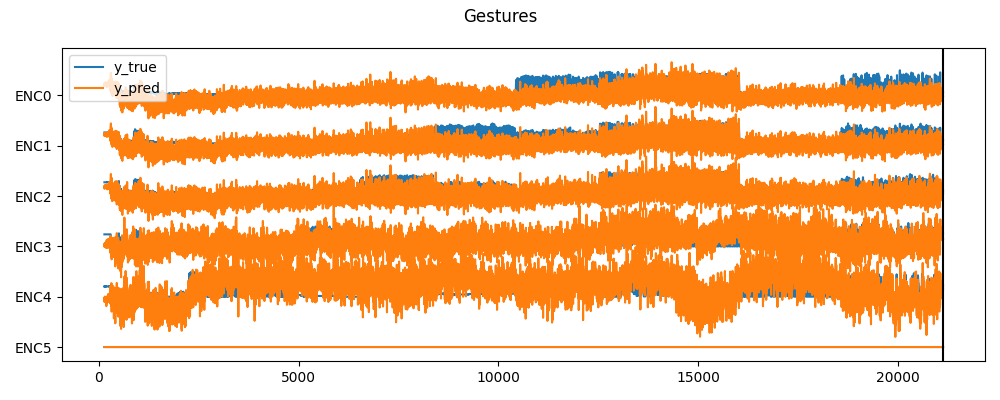

In [ ]:
Mout_f = MultiOutputRegressor(Ridge(random_state=seed_value))
# Model training
Mout_f.fit(X_train, y_train)

# Predict target values
#y_pred_f = Mout_f.predict(X_free)
y_pred_f = pd.DataFrame(Mout.predict(X_free), columns=GLOVE_CH, index=free_movements['ts'])

# Display metrics
get_mse(y_free, y_pred_f)

# Display comparison plot
get_signals_comparison_plot(y_free, y_free, y_pred=y_pred_f, only_test=1)

MSE metrics for Test: 
--------


ENC0     944.418390
ENC1    1036.379562
ENC2    1037.648785
ENC3    1091.758456
ENC4    3354.414245
dtype: float64

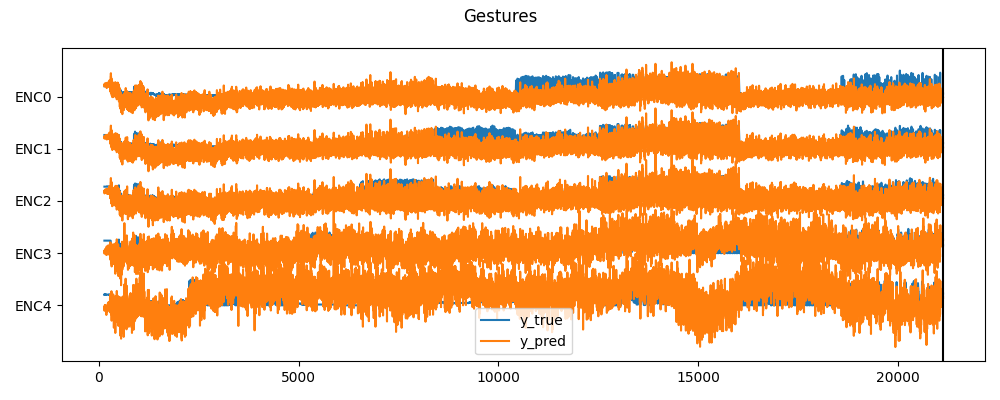

In [ ]:
rfr_f = RandomForestRegressor(
    n_estimators=20, 
    verbose=0, n_jobs=-1,
    #max_depth=6, min_samples_leaf=2,
    random_state=seed_value)

# Model training
rfr_f.fit(X_train, y_train)

# Prediction target values
#y_pred_rfr_f = rfr_f.predict(X_free)

# Transforming the target to DataFrame
y_pred_rfr_f = pd.DataFrame(Mout.predict(X_free), columns=GLOVE_CH, index=free_movements['ts']).round()

# Display metrics
get_mse(y_free, y_pred_rfr_f)

# Display comparison plot
get_signals_comparison_plot(y_free, y_free, y_pred=y_pred_rfr_f, only_test=1)

> Модель, обученная на протоколе, очень плохо предсказывает свободные жесты.

### Сокращение кол-ва признаков

In [ ]:
from sklearn.decomposition import PCA

# Number of the most important features
imp_features = 5
pca = PCA(n_components=imp_features)

# list of names
col_names = list()
for i in range(imp_features):
    col_names.append('col'+str(i)) 
    
X_train_pca, X_test_pca = pd.DataFrame(pca.fit_transform(X_train), columns=(col_names)), pd.DataFrame(pca.transform(X_test), columns=(col_names))
#X_train_pca.describe().T

MSE metrics for Test: 
--------


ENC0    163.309378
ENC1    152.473800
ENC2    153.410015
ENC3    458.157444
ENC4    598.438786
dtype: float64

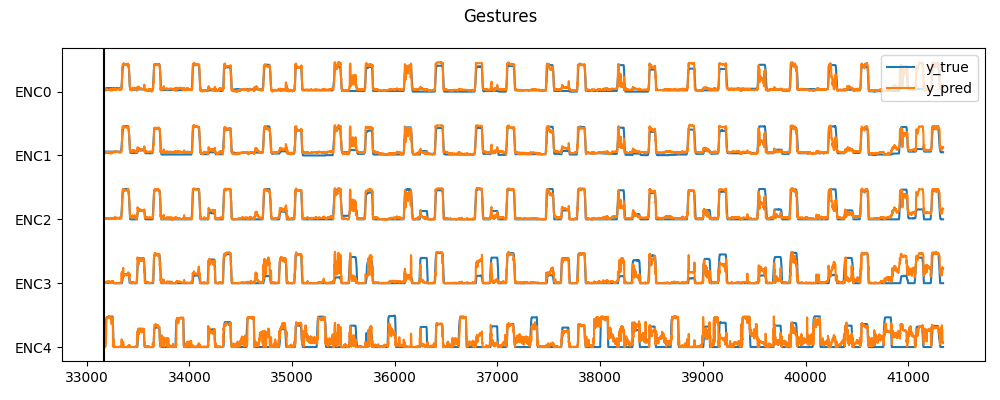

In [ ]:
# Model training
rfr.fit(X_train_pca, y_train)

# Transforming the target to DataFrame
y_pred_rfr = pd.DataFrame(rfr.predict(X_test_pca), columns=GLOVE_CH, index=gestures_test['ts']).round()

# Display metrics
get_mse(y_test, y_pred_rfr)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred_rfr, only_test=1)

### Signals scatter plot

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(init='pca') #verbose=10
tv = tsne.fit_transform(X_train)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 5

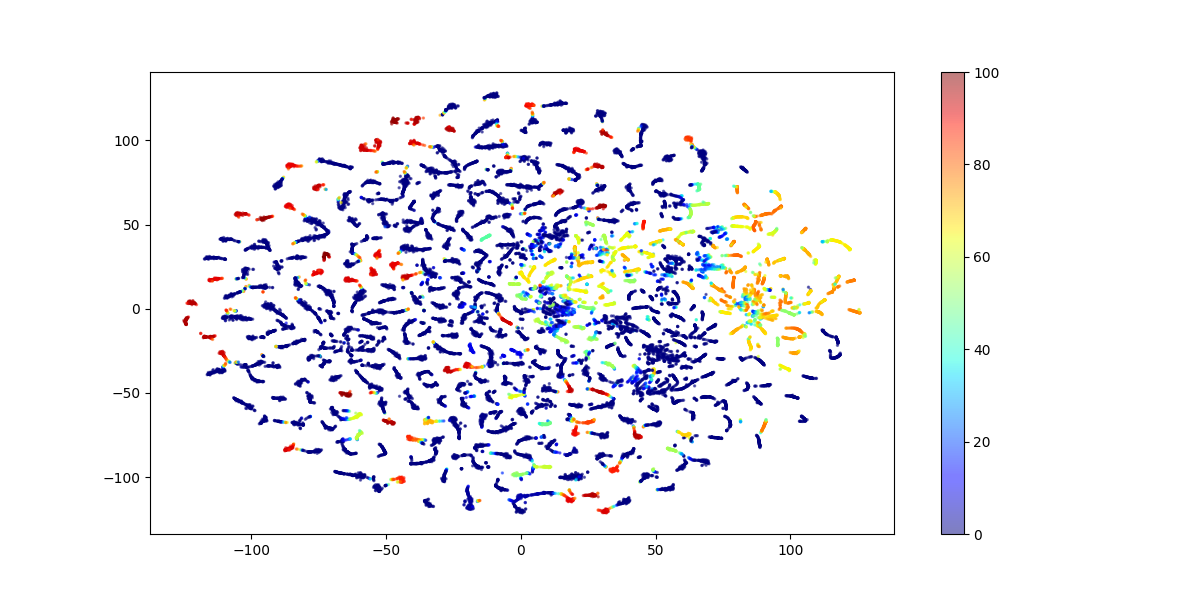

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(*(tv.T), 
            c = y_train['ENC4'], 
            s=2, 
            alpha=0.5, 
            cmap='jet')

fig = plt.colorbar() #label='digits'

#fig.set_ticks(np.arange(10))
#plt.set_xlabels(rotation=45)

for l in np.unique(y_train):
    mask = y_train==l
    t = plt.text(*tv[mask].mean(axis=0), l, ha='center', va='center', fontsize=20)
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='black'))

plt.tight_layout()

### Декомпозиция сигнала с учетом сезонности

In [26]:
gestures_train['timestamp'] = pd.to_datetime(gestures_train['ts']).astype(np.datetime64)
gestures_train['timestamp'].head()

0   1970-01-01 00:00:00.006492378
1   1970-01-01 00:00:00.006492411
2   1970-01-01 00:00:00.006492444
3   1970-01-01 00:00:00.006492477
4   1970-01-01 00:00:00.006492510
Name: timestamp, dtype: datetime64[ns]

In [28]:
X_train

0          1            2           3         4            5   \
0      1606.236207  -1.542537  1740.612301   92.159236  3.440420  2625.141283   
1      1603.392755   1.879782  1736.489352   91.972305  4.448692  2619.426829   
2      1600.694381   4.738870  1732.870430   91.859556  5.375269  2614.051026   
3      1598.136852   7.083463  1729.722418   91.812525  6.222640  2609.003156   
4      1595.715983   8.960495  1727.013182   91.823104  6.993297  2604.272600   
...            ...        ...          ...         ...       ...          ...   
33167  1466.414769   7.072526  1857.467077  103.422634  6.610447  2546.709650   
33168  1466.692973   8.383668  1857.912643  103.510439  6.708675  2546.109722   
33169  1466.981894  10.065967  1858.569963  103.578820  6.812383  2545.409230   
33170  1467.280132  12.154405  1859.451478  103.625188  6.920733  2544.599111   
33171  1467.586165  14.685207  1860.569880  103.646841  7.032824  2543.669948   

              6          7            8          9   ...         40  \
0      32.827590  27.949670  2060.559568  38.523687  ...  20.668754   
1      32.736187  28.306836  2057.512216  39.110853  ...  20.263036   
2      32.656839  28.627227  2054.815872  39.559915  ...  19.891251   
3      32.588066  28.913497  2052.450306  39.883450  ...  19.551675   
4      32.528455  29.168212  2050.395824  40.093580  ...  19.242623   
...          ...        ...          ...        ...  ...        ...   
33167  28.871733  34.802068  2189.504153  40.489027  ...  19.606461   
33168  28.909139  34.810766  2188.852341  40.242347  ...  19.469761   
33169  28.967896  34.814461  2188.188122  39.935380  ...  19.290036   
33170  29.050590  34.812860  2187.507032  39.563026  ...  19.062933   
33171  29.159910  34.805669  2186.804334  39.120017  ...  18.783936   

              41        42         43        44         45         46  \
0      12.184733  8.493123  20.540023  5.396507   9.649952  19.953590   
1      11.988167  8.468272  21.781986  5.385583  10.118245  20.886089   
2      11.795356  8.464614  22.934657  5.370917  10.501487  21.686419   
3      11.607140  8.479881  24.002060  5.353645  10.806993  22.364365   
4      11.424304  8.511893  24.988122  5.334831  11.041814  22.929392   
...          ...       ...        ...       ...        ...        ...   
33167  11.745378  8.570509  29.923841  5.053132  10.712819  23.156140   
33168  11.615878  7.906422  28.834025  5.005414  11.017871  23.244766   
33169  11.437037  7.126247  27.578478  4.945750  11.356598  23.375424   
33170  11.203463  6.220117  26.144885  4.872671  11.730726  23.553296   
33171  10.909546  5.177807  24.520536  4.784643  12.142012  23.783782   

             47         48         49  
0      3.355388   8.851131  29.634012  
1      3.627953   9.110996  25.504809  
2      3.889214   9.347760  21.845934  
3      4.138648   9.562499  18.624803  
4      4.375777   9.756266  15.809894  
...         ...        ...        ...  
33167  7.471649  10.817378   6.742768  
33168  7.082311  11.240651   6.973446  
33169  6.598427  11.783745   7.241669  
33170  6.011958  12.458895   7.550184  
33171  5.314602  13.278806   7.901819  

[33172 rows x 50 columns]

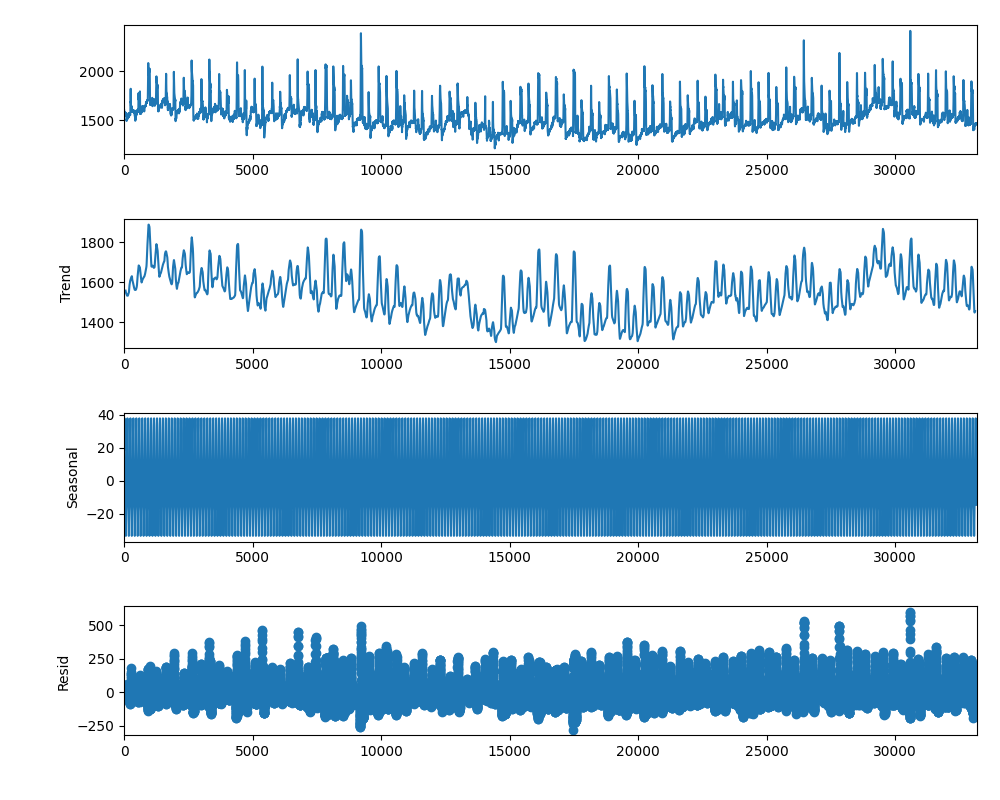

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

X = X_train_raw[['0']]
#X = X.set_index()#gestures_train['ts']
result = seasonal_decompose(X, period=115) #, model='multiplicative'
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()

In [ ]:
result.trend

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
33167   NaN
33168   NaN
33169   NaN
33170   NaN
33171   NaN
Name: trend, Length: 33172, dtype: float64

NameError: name 'result' is not defined

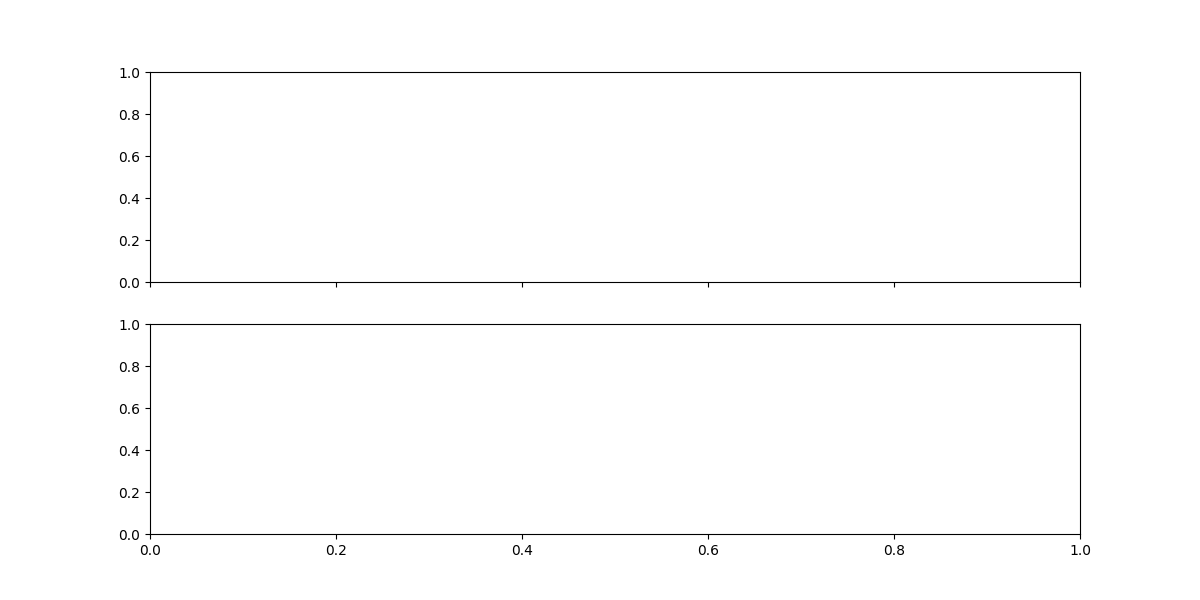

In [30]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax[0].plot(result.trend)
ax[0].set_title('Trend')
ax[1].plot(result.seasonal)

> Не получается извлечь тренд.
> Идея: получить тренд сигнала и сезонную компоненту, но убрать шум. 

### Сглаживание сигнала скользящим окном

In [ ]:
X_train_r = X_train.rolling(window=3).mean().dropna(axis=0)
X_test_r = X_test.rolling(window=3).mean().dropna(axis=0)
y_train_r, y_test_r =  y_train.iloc[2:,:], y_test.iloc[2:,]

MSE metrics for Test: 
--------


ENC0     58.915957
ENC1     35.312084
ENC2     38.432046
ENC3    215.119455
ENC4    468.394423
dtype: float64

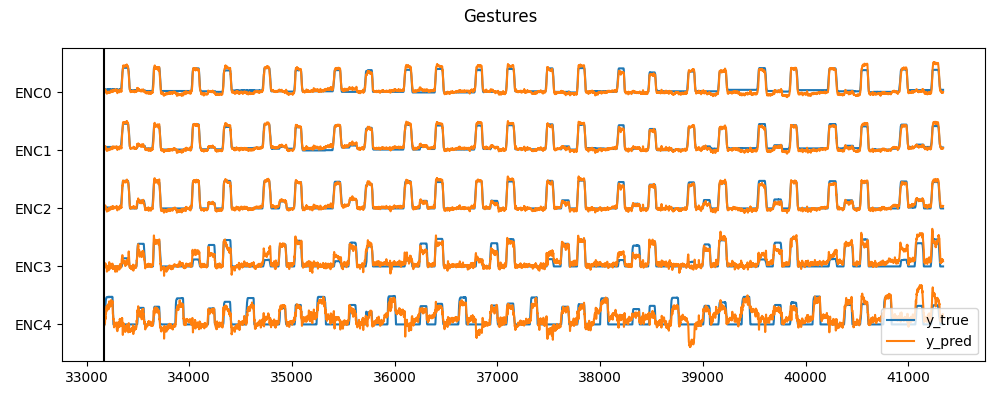

In [ ]:
Mout = MultiOutputRegressor(Ridge(random_state=seed_value))
# Model training
Mout.fit(X_train_r, y_train_r)

# Predict target values
y_pred = pd.DataFrame(Mout.predict(X_test_r), columns=GLOVE_CH, index=gestures_test['ts'][2:])

# Display metrics
get_mse(y_test_r, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train_r, y_test_r, y_pred=y_pred, only_test=1)

### Deque

In [ ]:
from collections import deque
a = np.array([[1],[2],[3]])
a

In [ ]:
dq = deque(a)
dq

In [ ]:
dq.append(np.array([4]))
dq

In [ ]:
dq.popleft()
dq

## Saving model

In [ ]:
# Save model to the given path in the pkl format
model_name = 'rfr'
full_path = os.path.join(config.PATH_MODEL, model_name + '.pkl')  
 
with open(full_path, 'wb') as f:
    pickle.dump(rfr, f)

# Real-time inference

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])[0] 
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [ ]:
df_sim = gestures_test.copy()
# df_sim = free_movements.iloc[:10000]
print(df_sim.shape)

(8168, 65)


In [ ]:
TIMEOUT = 0.033
DEBUG = True
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 539, TS: 7856565
[ 7 12  7  6 79  0]


In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 50)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


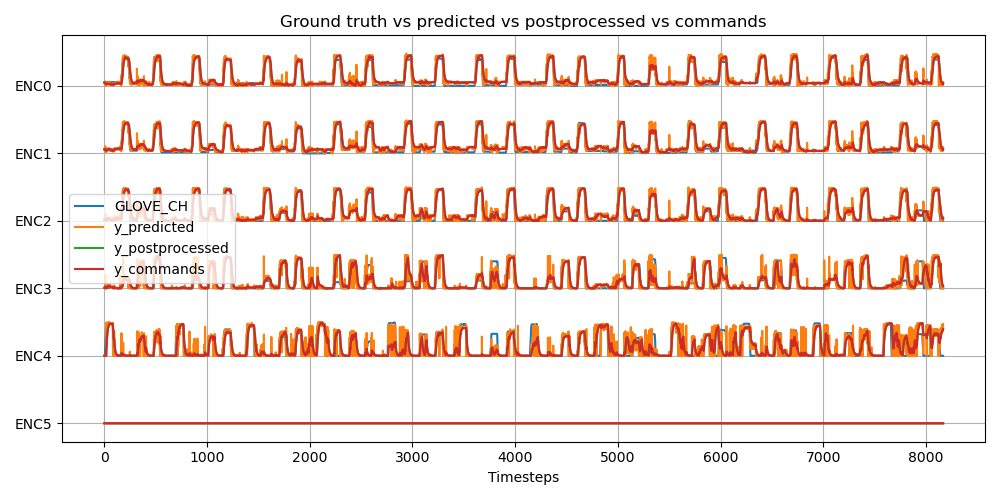

In [ ]:
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 